In [1]:
import sys
sys.path.append("D:/trading")  # o el path donde está tu carpeta my_modules

In [2]:
# ✅ CELDA 1: Preparación del entorno
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Cargar históricos locales
import os
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"Símbolos cargados: {len(historicos)}")




Símbolos cargados: 48


In [3]:
# ✅ CELDA 2: Grid de parámetros
param_grid = list(itertools.product(
    [True, False],              # usar_confirmacion_cruce
    [True, False],              # usar_filtro_volatilidad
    [0.006, 0.008, 0.010]       # atr_threshold
))
print(f"Total combinaciones: {len(param_grid)}")


# ✅ CELDA 3: Simulación por combinación
from my_modules.estrategias.v3 import macd_cruce_v3

def simular_combinacion(params):
    confirmar, usar_vol, atr_th = params
    resultados = []

    for ticker, df_precio in historicos.items():
        df_signals = macd_cruce_v3.generar_senales(
            df_precio,
            usar_confirmacion_cruce=confirmar,
            usar_filtro_volatilidad=usar_vol,
            atr_threshold=atr_th,
            debug=False
        )
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if df_signals.empty:
            continue

        df_precio = df_precio.copy()
        df_precio = df_precio.merge(df_signals[["fecha", "signal"]], on="fecha")

        for _, row in df_precio.iterrows():
            fecha_entrada = row["fecha"]
            precio_entrada = row["close"]
            df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) & (df_precio["fecha"] <= fecha_entrada + pd.Timedelta(days=7))]
            if df_rango.empty:
                continue

            tipo_salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * 1.05:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["low"] <= precio_entrada * 0.97:
                        tipo_salida = "SL"; fila_salida = f; break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * 0.95:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["high"] >= precio_entrada * 1.03:
                        tipo_salida = "SL"; fila_salida = f; break

            precio_salida = fila_salida["close"]
            dias = (fila_salida["fecha"] - fecha_entrada).days
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "resultado": resultado,
                "resultado_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0),
                "dias": dias
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "usar_confirmacion_cruce": confirmar,
            "usar_filtro_volatilidad": usar_vol,
            "atr_threshold": atr_th,
            "n_trades": 0,
            "winrate": 0,
            "avg_profit": 0,
            "score": -999
        }

    return {
        "usar_confirmacion_cruce": confirmar,
        "usar_filtro_volatilidad": usar_vol,
        "atr_threshold": atr_th,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }


Total combinaciones: 12


In [4]:
# ✅ CELDA 4: Ejecutar grid y mostrar resultados
resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(params) for params in tqdm(param_grid)
)

df_tuning = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)
print("Top combinaciones por score:")
display(df_tuning.head(10))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 97.56it/s]


Top combinaciones por score:


,usar_confirmacion_cruce,usar_filtro_volatilidad,atr_threshold,n_trades,winrate,avg_profit,score
0,True,False,0.006,2598,0.043495,-2.220350,-0.096574
1,True,False,0.008,2598,0.043495,-2.220350,-0.096574
2,True,False,0.010,2598,0.043495,-2.220350,-0.096574
3,True,True,0.010,2498,0.042834,-2.290083,-0.098094
4,True,True,0.008,2546,0.043598,-2.255224,-0.098323
5,True,True,0.006,2561,0.044123,-2.242883,-0.098964
6,False,False,0.008,3774,0.066243,-2.024744,-0.134125
7,False,False,0.006,3774,0.066243,-2.024744,-0.134125
8,False,False,0.010,3774,0.066243,-2.024744,-0.134125
9,False,True,0.006,3717,0.066182,-2.047199,-0.135489


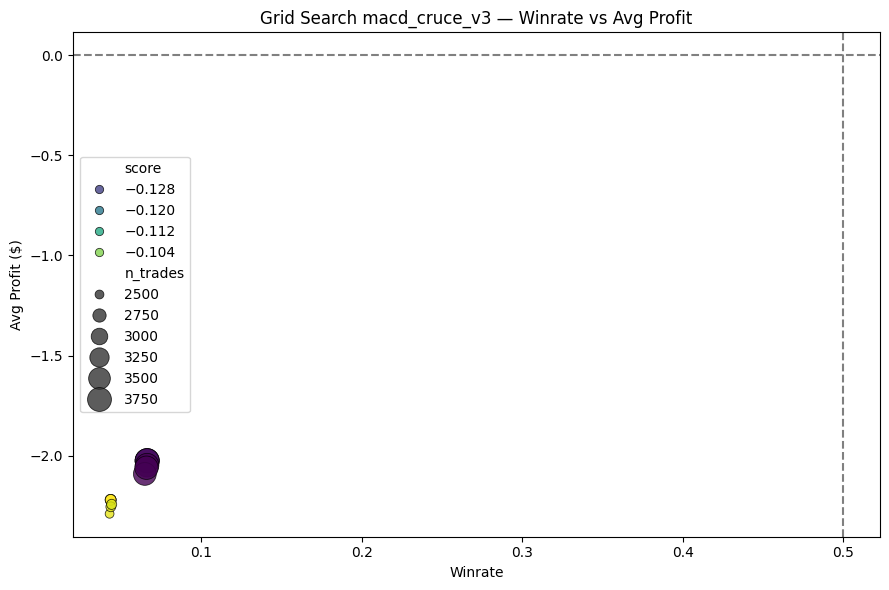

In [5]:
# ✅ CELDA 5: Visualizar scatterplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tuning,
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    palette="viridis",
    sizes=(40, 300),
    edgecolor="black",
    alpha=0.8
)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")
plt.title("Grid Search macd_cruce_v3 — Winrate vs Avg Profit")
plt.xlabel("Winrate")
plt.ylabel("Avg Profit ($)")
plt.tight_layout()
plt.show()

In [6]:
# ✅ CELDA 6: Conclusión final del tuning
from IPython.display import Markdown, display

def markdown_conclusion():
    display(Markdown(r"""
### 📌 Conclusión del tuning — macd_cruce_v3

> Análisis ejecutado sobre 12 combinaciones de parámetros (confirmación, ATR y volatilidad) evaluadas en 48 símbolos históricos (2005–2025).

**Resultados generales:**
- Ninguna combinación de parámetros logra profit positivo.
- El `winrate` promedio oscila entre 4.3% y 6.6%, muy inferior al mínimo aceptable.
- El `avg_profit` por trade es consistentemente **negativo** (pérdidas de ~$2.20 por operación en promedio).
- El `score` de todas las combinaciones es negativo.

**Mejor combinación relativa:**
```text
usar_confirmacion_cruce = True
usar_filtro_volatilidad = False
atr_threshold = 0.006
```
Aún así, esta configuración arroja resultados no rentables.

---
### ❌ Conclusión profesional:
La estrategia `macd_cruce_v3` **no presenta edge estadístico útil** ni consistencia suficiente para justificar su uso o evolución futura bajo la lógica actual.

### ✅ Recomendación:
Descartar esta variante para producción y enfocar esfuerzos de tuning en otras estrategias más prometedoras.
"""))

markdown_conclusion()


### 📌 Conclusión del tuning — macd_cruce_v3

> Análisis ejecutado sobre 12 combinaciones de parámetros (confirmación, ATR y volatilidad) evaluadas en 48 símbolos históricos (2005–2025).

**Resultados generales:**
- Ninguna combinación de parámetros logra profit positivo.
- El `winrate` promedio oscila entre 4.3% y 6.6%, muy inferior al mínimo aceptable.
- El `avg_profit` por trade es consistentemente **negativo** (pérdidas de ~$2.20 por operación en promedio).
- El `score` de todas las combinaciones es negativo.

**Mejor combinación relativa:**
```text
usar_confirmacion_cruce = True
usar_filtro_volatilidad = False
atr_threshold = 0.006
```
Aún así, esta configuración arroja resultados no rentables.

---
### ❌ Conclusión profesional:
La estrategia `macd_cruce_v3` **no presenta edge estadístico útil** ni consistencia suficiente para justificar su uso o evolución futura bajo la lógica actual.

### ✅ Recomendación:
Descartar esta variante para producción y enfocar esfuerzos de tuning en otras estrategias más prometedoras.
